# Cluster Before and After Corpora

In this notebook, we want to use <b>Cluster & Topic Modeling</b> techniques introduced in **Week 3** so as to cluster all film plots aired in pre-2008 Recession period as well as in post-2008 Recession period. We are interested to find out what are the top words in each cluster?

For this notebook we will be using the following packages:

In [13]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import nltk #the Natural Language Toolkit
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

import warnings
warnings.filterwarnings('ignore')

## Load and Process Data

Here we load the raw data sets, label each plot, and then merge all plots into a comprehensive dataframe.

In [14]:
preDF = pandas.read_csv('../Data/pre_plot.csv') 
postDF = pandas.read_csv('../Data/post_plot.csv')

In [15]:
preDF.shape

(6477, 4)

In [16]:
postDF.shape

(14654, 4)

For the sake of meaningful words, use tf-idf to filter our data.

To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

For pre-Recession Corpora:

In [17]:
preTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.7, min_df=10, 
                                                                  stop_words='english', norm='l2')
preplotTFVects = preTFVectorizer.fit_transform(preDF['plot'])

For post-Recession Corpora:

In [18]:
postTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.7, max_features=1000, 
                                                                  min_df=3, stop_words='english', norm='l2')
postplotTFVects = postTFVectorizer.fit_transform(postDF['plot'])

To construct visualizations of the clusters. First, we will first reduce the dimensionality of the data using principal components analysis (PCA).

In [19]:
def reduceDim(TFVects, n_component):
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components = n_component).fit(TFVects.toarray())
    reduced_data = pca.transform(TFVects.toarray())
    return reduced_data

Try setting number of components to 2 for each corpora

In [27]:
preplotReduced = reduceDim(preplotTFVects, 2)
postplotReduced = reduceDim(postplotTFVects, 2)

## Flat Clustering with K-means

We don't have the "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we would use the Silhouette method. 

Define a helper first for plotting:

In [21]:
def plotSilhouette(n_clusters, TFVects, reduced_data):
    TFVectToarray = TFVects.toarray()
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(TFVectToarray) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(TFVectToarray)
    
    silhouette_avg = sklearn.metrics.silhouette_score(TFVectToarray, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(TFVectToarray, cluster_labels)

    y_lower = 10

    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = matplotlib.cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components = 2).fit(TFVectToarray)
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Define another helper for computing averaged Silhouette score

In [22]:
def silhouetteAvg(n_clusters, TFVects, reduced_data, pca_component):
    TFVectToarray = TFVects.toarray()

    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(TFVectToarray)
    
    silhouette_avg = sklearn.metrics.silhouette_score(TFVectToarray, cluster_labels)
    return silhouette_avg

Tuning the optimal number of clusters for each corpora

In [ ]:
PRE_scoreTunels1 = []
for i in range(2, 100):
    PRE_scoreTunels1.append(silhouetteAvg(i, preplotTFVects, preplotReduced, 2))

In [ ]:
PRE_scoreTunels = []
for i in range(2, 40):
    PRE_scoreTunels.append(silhouetteAvg(i, preplotTFVects, preplotReduced))

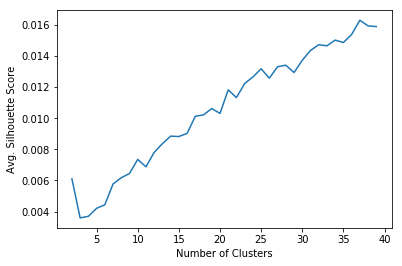

In [103]:
plt.plot(range(2,40), PRE_scoreTunels)
plt.xlabel('Number of Clusters')
plt.ylabel('Avg. Silhouette Score')
plt.show()

It makes sense to see as we increase the number of clusters, the averaged Silhouette score increases consistently. Thus, we choose to an optimal cluster of 10 for pre-Recession corpora.

In [94]:
POST_scoreTunels = []
for i in range(2, 40):
    POST_scoreTunels.append(silhouetteAvg(i, postplotTFVects, postplotReduced))

In [96]:
POST_scoreTunels

[0.0060283927721667685,
 0.0050385634357698805,
 0.0044973512577296485,
 0.004285336923874893,
 0.004849742178599839,
 0.005167207944645549,
 0.005708449751710743,
 0.00596022465630094,
 0.006405290850299449,
 0.006936775326578001,
 0.007288728129989332,
 0.0074953939242597255,
 0.007886681626577293,
 0.008104095968385199,
 0.00851363225855225,
 0.008473362448421281,
 0.0090588369012659,
 0.00952417015101219,
 0.00980708171864837,
 0.010157925074871213,
 0.009407639162309326,
 0.01061792924198375,
 0.011406864851413878,
 0.011227986459145058,
 0.011628271627584274,
 0.011492414082705406,
 0.012138899883692256,
 0.012350577478259385,
 0.012518986419138692,
 0.012836240127298962,
 0.01294105239728801,
 0.012822283616961899,
 0.013188281280746792,
 0.012997013157756825,
 0.0146534621912486,
 0.013455393224340872,
 0.014744040292445616,
 0.014350692670936492]

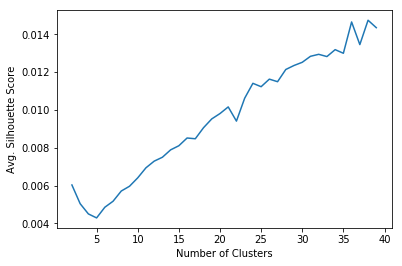

In [104]:
plt.plot(range(2,40), POST_scoreTunels)
plt.xlabel('Number of Clusters')
plt.ylabel('Avg. Silhouette Score')
plt.show()

We choose to an optimal cluster of 21 for post-Recession corpora.

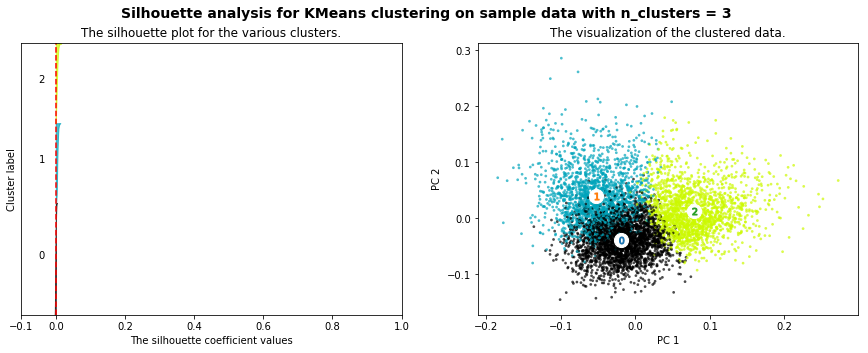

For n_clusters = 3, The average silhouette_score is : 0.002


In [26]:
plotSilhouette(3, preplotTFVects, preplotReduced)

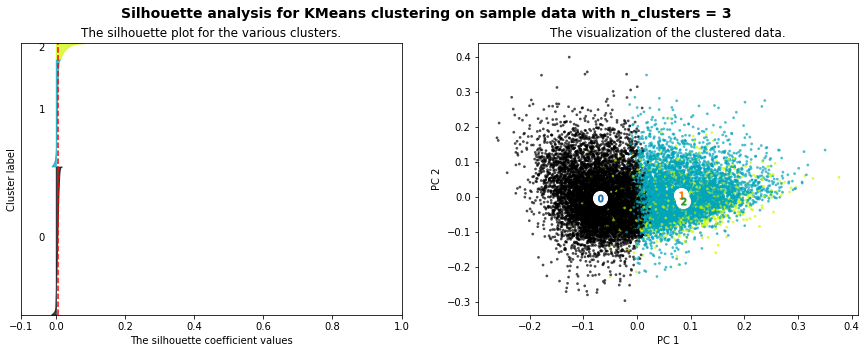

For n_clusters = 3, The average silhouette_score is : 0.005


In [29]:
plotSilhouette(3, postplotTFVects, postplotReduced)

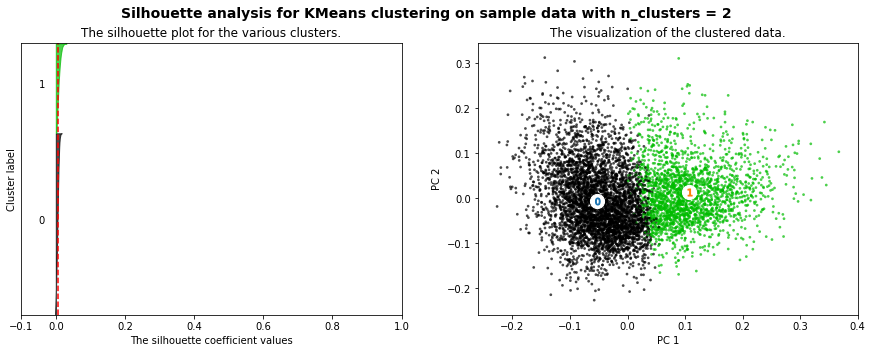

For n_clusters = 2, The average silhouette_score is : 0.006


In [174]:
plotSilhouette(2, preplotTFVects, preplotReduced)

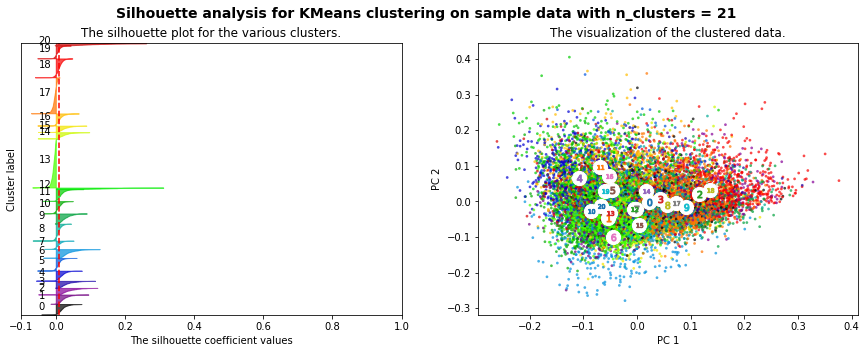

For n_clusters = 21, The average silhouette_score is : 0.010


In [106]:
plotSilhouette(21, postplotTFVects, postplotReduced, 2)

# Top words for each cluster for Pre-Recession Corpora

In [9]:
preTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.8, min_df=20, 
                                                                  stop_words='english', norm='l2')
preplotTFVects = preTFVectorizer.fit_transform(preDF['plot'])
numClusters = 10
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km.fit(preplotTFVects)
terms = preTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 jack
 life
 friend
 best
 elizabeth
 wife
 love
 mr
 son
 man
 new
 time
 death
 old
 finds
 years
 father
 girlfriend
 story
 wants


Cluster 1:
 town
 war
 evil
 group
 man
 world
 young
 small
 people
 local
 men
 american
 death
 killer
 years
 lives
 murder
 way
 time
 secret


Cluster 2:
 family
 father
 life
 home
 old
 mother
 son
 love
 young
 man
 year
 story
 years
 new
 brother
 wife
 past
 daughter
 finds
 death


Cluster 3:
 film
 documentary
 interviews
 footage
 life
 movie
 american
 world
 war
 films
 people
 filmmaker
 feature
 art
 history
 director
 look
 years
 america
 stories


Cluster 4:
 story
 world
 life
 love
 journey
 people
 lives
 women
 man
 young
 time
 true
 years
 film
 tells
 way
 stories
 struggle
 new
 set


Cluster 5:
 music
 band
 rock
 hip
 hop
 documentary
 musicians
 film
 punk
 musical
 bands
 world
 interviews
 live
 story
 performances
 jazz
 roll
 artists
 scene


Cluster 6:
 new
 york
 city
 life
 film


From keywords of each clusters, we are able to detect popular clusters such as:
1. school
2. town killer
3. Live in New York City
4. sports
5. love
6. war
7. music

In [8]:
postTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.7, min_df=20, stop_words='english', norm='l2')
postplotTFVects = postTFVectorizer.fit_transform(postDF['plot'])
numClusters = 10
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km.fit(postplotTFVects)
terms = postTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 music
 band
 rock
 musicians
 musical
 film
 tour
 story
 bands
 world
 documentary
 singer
 jazz
 album
 roll
 concert
 punk
 new
 songs
 life


Cluster 1:
 world
 documentary
 people
 story
 american
 war
 america
 film
 history
 years
 journey
 time
 stories
 community
 lives
 human
 children
 country
 life
 united


Cluster 2:
 school
 high
 students
 college
 friends
 life
 student
 year
 teacher
 best
 new
 story
 team
 old
 senior
 group
 friend
 education
 young
 girl


Cluster 3:
 town
 small
 life
 local
 story
 sheriff
 young
 new
 community
 years
 old
 home
 night
 man
 people
 way
 group
 friends
 love
 world


Cluster 4:
 women
 men
 film
 documentary
 lives
 life
 female
 story
 world
 woman
 girls
 stories
 love
 young
 sex
 years
 american
 day
 work
 follows


Cluster 5:
 family
 father
 mother
 son
 daughter
 life
 home
 old
 year
 years
 young
 brother
 children
 man
 wife
 story
 death
 love
 sister
 new


Cluster 6:
 film
 art
 

1. New York City
2. Relationship
3. Family
4. Crime
5. School
6. Town
7. Music